## Chinook Database
__[Source link](https://github.com/lerocha/chinook-database)__
* Chinook is a sample database available for SQL Server, Oracle, MySQL, etc. 
* The Chinook data represents a digital media store, including tables for artists, albums, media tracks, invoices and customers
* There are 11 tables in this databas
* Total 59 customers from 24 different countries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        return conn.execute(c)

In [4]:
def show_tables():
    q = """
    SELECT name,type
    FROM sqlite_master
    WHERE type IN ("table","view");"""
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [6]:
album_to_pur_all = """
WITH track_pur AS
    (
     SELECT il.*, c.country
     FROM invoice_line il
     INNER JOIN invoice i on il.invoice_id = i.invoice_id
     INNER JOIN customer c on i.customer_id = c.customer_id
    )

SELECT  tp.country,
        COUNT(tp.invoice_line_id) "number_tracks_sold"
FROM track_pur tp
INNER JOIN track t on tp.track_id = t.track_id
INNER JOIN genre g on t.genre_id = g.genre_id
GROUP BY tp.country
ORDER BY number_tracks_sold DESC
"""

In [7]:
genre_sales_all = run_query(album_to_pur_all)

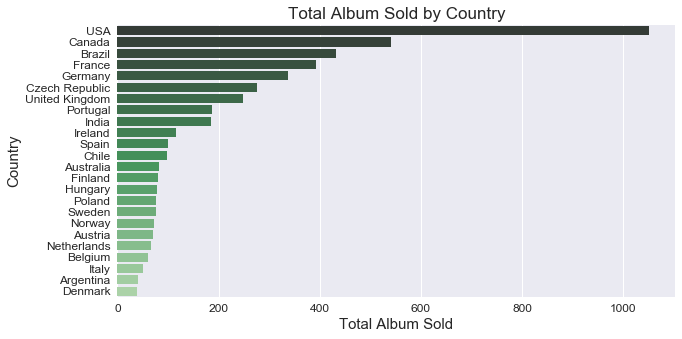

In [25]:
sns.set_style('darkgrid')
sns.set(font_scale=1.2)
plt.figure(figsize=(10,5))
pal = sns.color_palette("Greens_d", 24)
sns.barplot(x='number_tracks_sold', y ='country',
            data= genre_sales_all, ci = None, palette=pal)
plt.title('Total Album Sold by Country', fontsize=17)
plt.xlabel('Total Album Sold', fontsize=15)
plt.ylabel('Country', fontsize=15)
plt.show()

* From the bar plot, USA is the biggest market for Chinook store

# Top 10 sold genre in USA

In [14]:
album_to_pur_usa = """
WITH track_pur AS
    (
     SELECT il.* 
     FROM invoice_line il
     INNER JOIN invoice i on il.invoice_id = i.invoice_id
     INNER JOIN customer c on i.customer_id = c.customer_id
     WHERE c.country = "USA"
    )

SELECT  g.name genre, 
        COUNT(tp.invoice_line_id) "number_tracks_sold",
        CAST(COUNT(tp.invoice_line_id) as float)/(
        SELECT count(*) FROM track_pur) "%_tracks_sold"
FROM track_pur tp
INNER JOIN track t on tp.track_id = t.track_id
INNER JOIN genre g on t.genre_id = g.genre_id
GROUP BY g.genre_id
ORDER BY number_tracks_sold DESC
"""

In [15]:
genre_sales_usa = run_query(album_to_pur_usa)

In [16]:
genre_sales_usa

,genre,number_tracks_sold,%_tracks_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


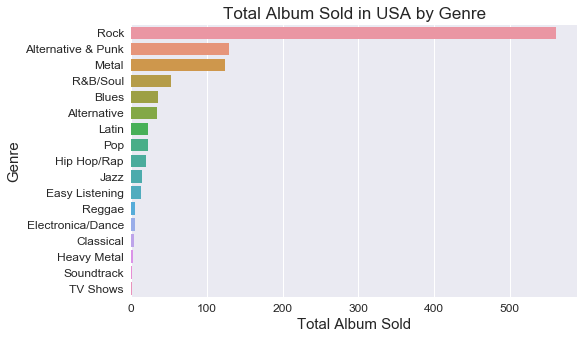

In [26]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,5))
sns.barplot(x='number_tracks_sold', y ='genre',data= genre_sales_usa)
plt.title('Total Album Sold in USA by Genre', fontsize=17)
plt.xlabel('Total Album Sold', fontsize=15)
plt.ylabel('Genre', fontsize=15)
plt.show()

* From the bar plot, genre "Rock", "Alternative & Punk", and "Metal" are the top three most sold genre in the store
* Store owner should lookout for artists and albums from the thoes three genres which account for 76% of store sales for USA customers

# Check employees' perfromance

In [183]:
sales_performance = """
WITH emp_cust AS
        (
         SELECT e.first_name||" "||e.last_name employee_name, 
                e.title, e.hire_date, e.country, 
                c.customer_id
         FROM employee e
         LEFT JOIN customer c on e.employee_id = c.support_rep_id
         )

SELECT ec.employee_name, ec.title employee_title, 
       ec.hire_date,
       ec.country employee_country,
       COUNT(DISTINCT ec.customer_id) num_customer,
       SUM(i.total) total_cust_sales
FROM emp_cust ec
INNER JOIN invoice i on i.customer_id = ec.customer_id
GROUP BY ec.employee_name
"""

In [184]:
sales_performance_table = run_query(sales_performance)

In [185]:
sales_performance_table

,employee_name,employee_title,hire_date,employee_country,num_customer,total_cust_sales
0,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,Canada,21,1731.51
1,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,Canada,20,1584.00
2,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,Canada,18,1393.92


# Customer sales data table (by Country)
* If a country has only one customer, categorize them into "Other countries" 
* Note: use a trick to put "Other countries" category at the very bottom

In [27]:
# case_country: case country to "Other countries" if only one customer
# when country = "Other countries" THEN 1ELSE 0
country_sales = """
WITH case_country AS
    (
    SELECT i.invoice_id, c.customer_id, i.total,
            CASE
                WHEN (
                     SELECT count(*)
                     FROM customer
                     where country = c.country
                     )=1 THEN "Other countries"
                ELSE c.country
            END AS country
    FROM invoice i 
    INNER JOIN customer c on i.customer_id = c.customer_id
    )
    
SELECT c.country,
       COUNT(DISTINCT c.customer_id) Total_customer, 
       COUNT(c.invoice_id) Total_order, 
       SUM(c.total) Total_sales,
       SUM(c.total)/COUNT(c.invoice_id) Avg_order_sales
FROM (
      SELECT c.*, 
             CASE
                 WHEN country = "Other countries" THEN 1
                 ELSE 0
             END AS sort
      FROM case_country c) c
GROUP BY c.country
ORDER BY c.sort, Total_sales DESC
"""

In [67]:
country_sales_table = run_query(country_sales)
country_sales_table

,country,Total_customer,Total_order,Total_sales,Avg_order_sales
0,USA,13,131,1040.49,7.942672
1,Canada,8,76,535.59,7.047237
2,Brazil,5,61,427.68,7.011148
3,France,5,50,389.07,7.781400
4,Germany,4,41,334.62,8.161463
5,Czech Republic,2,30,273.24,9.108000
6,United Kingdom,3,28,245.52,8.768571
7,Portugal,2,29,185.13,6.383793
8,India,2,21,183.15,8.721429
9,Other countries,15,147,1094.94,7.448571


Text(0.5,1,'Average Sales per Order by Country')

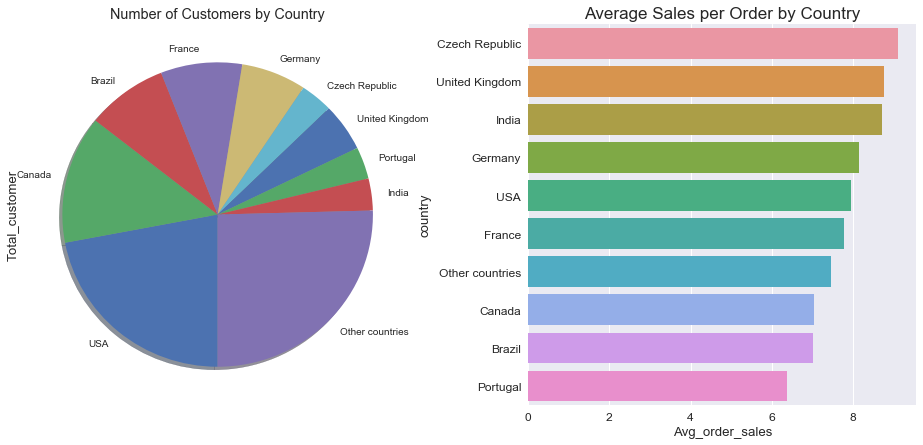

In [97]:
sns.set(font_scale=1.2)
fig, axs = plt.subplots(ncols=2,figsize=(16, 7))
fig.subplots_adjust(hspace=.5, wspace=.3)

# pie chart
country_sales_table_p = run_query(country_sales)
country_sales_table_p.set_index("country", drop=True, inplace=True)
country_sales_table_p.plot.pie(
    y='Total_customer',
    ax=axs[0],
    counterclock=False,
    title='Number of Customers by Country',
    fontsize=10,
    startangle=-90,
    legend =None,
    shadow=True
)
# bar chart
sns.barplot(x='Avg_order_sales',y='country', data = country_sales_table.sort_values(by='Avg_order_sales', ascending = False),ax=axs[1])
plt.title('Average Sales per Order by Country', fontsize=17)

* From the pie chart, USA and Canada have largest number of customers compared with other countries, followed by Brazil, France, and Germany
* From the bar chart, customers from Czech Republic, UK, and India have relatively larger spending per order
* This finding can help sales team on making better decision of resource reallocation strategy, i.e. spending time and cost on valueable customers


# Which artist is used in the most playlists?

In [149]:
artist_playlist = """
WITH artist_playlist AS
    (
    SELECT a.name artist_name,
           p.name playlist_name  
    FROM artist a
    INNER JOIN album al on a.artist_id = al.artist_id
    INNER JOIN track t on al.album_id = t.album_id
    INNER JOIN playlist_track pt on t.track_id = pt.track_id
    INNER JOIN playlist p on pt.playlist_id = p.playlist_id
    GROUP BY artist_name, playlist_name
    )
SELECT artist_name, 
       COUNT(playlist_name) number_playlist
FROM artist_playlist
GROUP BY artist_name
ORDER BY number_playlist DESC
"""

In [150]:
a = run_query(artist_playlist)

In [153]:
a.head()

,artist_name,number_playlist
0,Eugene Ormandy,6
1,Academy of St. Martin in the Fields & Sir Nevi...,5
2,Berliner Philharmoniker & Herbert Von Karajan,5
3,English Concert & Trevor Pinnock,5
4,The King's Singers,5


* __Artist Eugene Ormandy is included in 6 different playlists__

# How many tracks have been purchased vs not purchased?

In [220]:
track_pur = """
WITH track_sold AS
    (
    SELECT t.name track_name,
           COUNT(DISTINCT invoice_id) number_sold
    FROM track t
    LEFT JOIN invoice_line il on t.track_id = il.track_id
    GROUP BY track_name  
    ORDER BY number_sold DESC
    )
    
SELECT purchased,
       COUNT(*) number_tracks
FROM (
      SELECT *, 
             CASE
                 WHEN number_sold != 0 THEN "yes"
                 ELSE "no"
             END AS purchased
      FROM track_sold
     )
GROUP BY purchased
"""

In [221]:
track_pur_table = run_query(track_pur)

In [223]:
track_pur_table

,purchased,number_tracks
0,no,1523
1,yes,1734


* There are 1734 tracks have been purchased and 1523 tracks have not been purchased

# Do protected vs non-protected media types have an effect on popularity?

In [240]:
track_media = """
SELECT m.name media_type,
        COUNT(DISTINCT t.track_id) number_tracks,
       COUNT(il.invoice_id) number_purchased,
       CAST(COUNT(il.invoice_id) AS Float)/COUNT(DISTINCT t.track_id) Avg_purchase_times
FROM invoice_line il
INNER JOIN track t on il.track_id = t.track_id
INNER JOIN media_type m on t.media_type_id = m.media_type_id
GROUP BY media_type
"""

In [241]:
run_query(track_media)

,media_type,number_tracks,number_purchased,Avg_purchase_times
0,AAC audio file,8,21,2.625000
1,MPEG audio file,1641,4259,2.595369
2,Protected AAC audio file,151,439,2.907285
3,Protected MPEG-4 video file,3,3,1.000000
4,Purchased AAC audio file,3,35,11.666667


* (For tracks that have been purchased and have media type)
* There are 154 tracks under protected media types and 1652 tracks under non-protected types
* __Protected AAC audio file__ has __slightly higher__ average purchased times among all media types